## 1. Calculate the gene expression score

In [ ]:
import os,gc
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np

os.chdir("/data/wuqinhua/scPhase/Age")

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: 

In [ ]:
adata = sc.read('./ensemble_adata_with_attention.h5ad')
print("read_over")

age_gene = pd.read_csv("./ensemble_gene_attributions_regression.csv") 
top_200 = age_gene.sort_values(by='mean_attribution', ascending=False).head(200)
top_200 = top_200['gene'].tolist()

bottom_200 = age_gene.sort_values(by='mean_attribution', ascending=True).head(200)
bottom_200 = bottom_200['gene'].tolist()

print("top100: ",top_200)
print("boottom100: ", bottom_200)
print("gene_over")


sc.tl.score_genes(adata, top_200, ctrl_size=200, gene_pool=None, n_bins=25, score_name='gene_ex_score', random_state=0, copy=False, use_raw=None)
adata.obs.to_csv('./Analysis/Figure/gene_ex_scores_top20.csv')
sc.tl.score_genes(adata, bottom_200, ctrl_size=200, gene_pool=None, n_bins=25, score_name='gene_ex_score', random_state=0, copy=False, use_raw=None)
adata.obs.to_csv('./Analysis/Figure/gene_ex_scores_bottom20.csv')

print("over")

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


read_over
top100:  ['INPP4B', 'TSHZ2', 'EDA', 'FHIT', 'ANK3', 'SELENOM', 'BCL2', 'FAM13A', 'LGALS1', 'TMEM238', 'CRIP2', 'AC139720.1', 'MAL', 'GTSCR1', 'PRKCQ-AS1', 'SYTL3', 'PCSK1N', 'STAT4', 'ADTRP', 'PIM1', 'SYNE2', 'SESN3', 'SUPT3H', 'GATA3', 'SCGB3A1', 'CTSW', 'PTGDS', 'ALOX5AP', 'SOCS1', 'NEFL', 'ILF3-DT', 'NCK2', 'SLC40A1', 'SOCS3', 'HIST1H1C', 'TESPA1', 'TBCC', 'HIST1H1D', 'AC005842.1', 'LINC00402', 'GSTM2', 'RGCC', 'BIRC3', 'FBLN5', 'BRI3', 'HLA-DPB1', 'RUNX2', 'YBX3', 'SLC35F1', 'RBM38', 'AQP3', 'CISH', 'AC245407.2', 'STMN3', 'NPC2', 'AL589693.1', 'LINC02762', 'FAAH2', 'RADX', 'ENO2', 'GPR183', 'AC092821.3', 'TCEA3', 'GPHN', 'CPQ', 'TIMP1', 'PTGER2', 'SH3YL1', 'GALNT2', 'DOK2', 'TRBV7-2', 'SGK1', 'SAMSN1', 'PSAP', 'CCDC167', 'LRRC7', 'NELL2', 'C20orf204', 'CFAP36', 'GNLY', 'AC103563.7', 'GLIPR2', 'CFAP97', 'EXOSC8', 'HNRNPLL', 'C12orf65', 'PATJ', 'HLA-DPA1', 'ZBTB38', 'GSTM3', 'ANKRD55', 'AP1S2', 'CD82', 'YEATS4', 'ABHD14A', 'MEGF9', 'TMX4', 'ANXA5', 'COA6-AS1', 'CASK', 'GCHF

## 2. Correlation scatter

In [1]:
setwd("/data/wuqinhua/scPhase/Age")
rm(list = ls())
gc()

library(cowplot) 
library(ggplot2) 
library(RColorBrewer) 
library(dplyr) 
library(tidyr)
library(ggpubr) 
library(broom)
library(tidyverse)
library(tibble)
library(janitor)
library(ggrepel)
library(tidyr)
library(ggplot2)
library(forestploter)
library(gridExtra)
library(tidyverse)
library(dplyr)
library(broom)
library(ggpubr)
library(randomForest)
library(mice)
library(reshape2)
library(gghalves)
library(cowplot)
library(patchwork)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,648530,34.7,1443531,77.1,1118357,59.8
Vcells,1205774,9.2,8388608,64.0,1924587,14.7



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
✔ purrr     1.0.2     ✔ tibble    3.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘gridExtra’


The following object is masked f

In [3]:
attnData <- read.csv('./metadata.csv')
sampleInfo <- read.csv('./sample_info.csv', row.names = 1)

nameAll_attn <- unique(attnData$celltype)
nameList_attn <- sort(nameAll_attn)

sampleFold_attn <- data.frame(id = character(), celltype = character(), fold = numeric())
idList_attn <- unique(attnData$Tube_id)

for (id in idList_attn) {
  attnTmp <- attnData %>% filter(Tube_id == id)
  avgScore <- 1 / dim(attnTmp)[1]
  foldRes <- attnTmp %>% group_by(celltype) %>% summarise(res = median(log2(attention_weight_mean / avgScore)))
  dataTmp <- data.frame(id = rep(id, dim(foldRes)[1]),
                       celltype = foldRes$celltype,
                       fold = foldRes$res)
  dataTmp_s <- dataTmp %>% filter(celltype %in% nameList_attn)
  dataTmp_s$fold <- scale(dataTmp_s$fold)
  sampleFold_attn <- rbind(sampleFold_attn, dataTmp_s)
}

sampleFold.Table <- dcast(sampleFold_attn, id ~ celltype)
rownames(sampleFold.Table) <- sampleFold.Table$id
sampleFold.Table$id <- NULL
attn <- sampleFold.Table

process_expression_data <- function(file_path) {
  exData <- read.csv(file_path, row.names = 1)
  nameAll <- unique(exData$celltype)
  nameList <- sort(nameAll)
  
  sampleFold <- data.frame(id = character(), celltype = character(), fold = numeric())
  idList <- unique(exData$Tube_id)
  
  for (id in idList) {
    attnTmp <- exData %>% filter(Tube_id == id)
    foldRes <- attnTmp %>% group_by(celltype) %>% summarise(res = median(gene_ex_score))
    dataTmp <- data.frame(id = rep(id, dim(foldRes)[1]),
                         celltype = foldRes$celltype,
                         fold = foldRes$res)
    dataTmp_s <- dataTmp %>% filter(celltype %in% nameList)
    sampleFold <- rbind(sampleFold, dataTmp_s)
  }
  
  ex_sampleFold.Table <- dcast(sampleFold, id ~ celltype)
  rownames(ex_sampleFold.Table) <- ex_sampleFold.Table$id
  ex_sampleFold.Table$id <- NULL
  return(ex_sampleFold.Table)
}

file_top <- "./Analysis/Figure/gene_ex_scores_top20.csv" 
file_bottom <- "./Analysis/Figure/gene_ex_scores_bottom20.csv"

ex_top <- process_expression_data(file_top)
ex_bottom <- process_expression_data(file_bottom)
head(sampleInfo)

sampleInfo <- sampleInfo[rownames(attn), ]
ex_top <- ex_top[rownames(attn), colnames(attn)]
ex_bottom <- ex_bottom[rownames(attn), colnames(attn)]

ex_diff <- ex_top - ex_bottom


Using fold as value column: use value.var to override.

Using fold as value column: use value.var to override.

Using fold as value column: use value.var to override.



,Donor_id,Age_group,Sex,Age,Tube_id,Batch,File_name
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
0,A23,A,Male,27,G23,AS044,ALAW-AS044-1
1,E15,E,Male,78,L15,AS044,ALAW-AS044-1
2,E07,E,Male,80,L07,AS044,ALAW-AS044-1
3,E13,E,Male,79,L13,AS044,ALAW-AS044-1
4,A20,A,Male,27,G20,AS044,ALAW-AS044-1
5,A15,A,Male,26,G15,AS044,ALAW-AS044-1


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


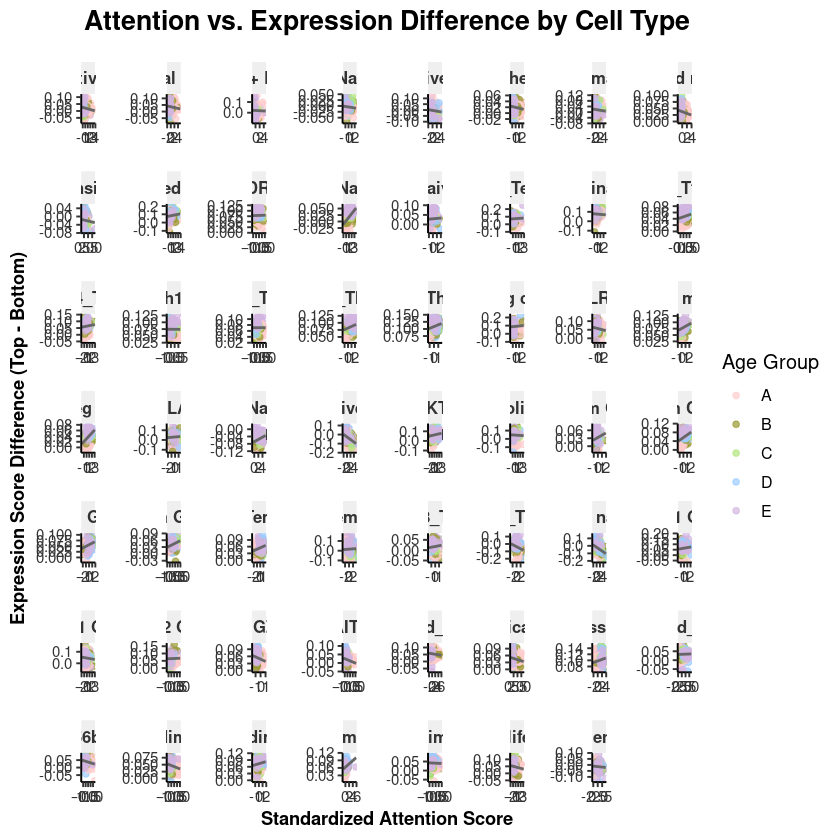

In [4]:
sampleInfo <- read.csv('./sample_info.csv', row.names = 1)
custom_colors <- c("A" = "#FFCCCC", "B" = "#999933", "C" = "#B0E57C", "D" = "#99CCFF", "E" = "#D2B5E1")

attn_long <- attn %>%
  tibble::rownames_to_column("sample") %>%
  pivot_longer(cols = -sample, names_to = "cell_type", values_to = "attn_value")

ex_diff_long <- ex_diff %>%
  tibble::rownames_to_column("sample") %>%
  pivot_longer(cols = -sample, names_to = "cell_type", values_to = "ex_diff_value")

plot_data_long <- attn_long %>%
  left_join(ex_diff_long, by = c("sample", "cell_type")) %>%
  left_join(sampleInfo %>% select(Tube_id, Age_group), by = c("sample" = "Tube_id")) %>%
  mutate(Age_group = factor(Age_group, levels = names(custom_colors))) %>%
  na.omit()

annotation_data <- plot_data_long %>%
  group_by(cell_type) %>%
  summarise(
    cor_test_res = list(cor.test(attn_value, ex_diff_value, method = "pearson")),
    pcc_value = cor_test_res[[1]]$estimate,
    p_value = cor_test_res[[1]]$p.value
  ) %>%
  mutate(
    significance = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01  ~ "**",
      p_value < 0.05  ~ "*",
      TRUE ~ ""
    ),
    title_with_sig = paste0(cell_type, " ", significance),
    label_string = paste0("PCC = ", round(pcc_value, 3), 
                          ", ", 
                          scales::pvalue(p_value, accuracy = 0.001, add_p = TRUE))
  )

plot_data_final <- plot_data_long %>%
  left_join(annotation_data %>% select(cell_type, title_with_sig), by = "cell_type")

final_plot <- ggplot(plot_data_final, aes(x = attn_value, y = ex_diff_value)) +
  
  geom_point(aes(color = Age_group), alpha = 0.7, size = 1.5) +
  
  geom_smooth(
    method = "lm", se = TRUE,
    color = "#666666", fill = "#C9C9C9",
    alpha = 0.25, linewidth = 0.8
  ) +

  geom_text(
    data = annotation_data, 
    aes(label = label_string), 
    x = -Inf, y = Inf,     
    hjust = -0.1, vjust = 1.5, 
    size = 3
  ) +
  
  scale_color_manual(values = custom_colors, name = "Age Group") +
  
  facet_wrap(~title_with_sig, scales = "free") +
  
  labs(
    title = "Attention vs. Expression Difference by Cell Type",
    x = "Standardized Attention Score",
    y = "Expression Score Difference (Top - Bottom)"
  ) +
  
  theme_classic(base_size = 12) +
  theme(
    panel.background = element_rect(fill = "white", color = NA),
    plot.background  = element_rect(fill = "white", color = NA),
    strip.background = element_rect(fill = "#EFEFEF", color = NA),
    strip.text = element_text(size = 10, face = "bold", color = "#333333"),
    axis.text = element_text(size = 9, color = "#333333"),
    axis.title = element_text(size = 11, face = "bold"),
    legend.position = "right",
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold", margin = ggplot2::margin(b = 15)),
    panel.spacing = unit(1, "lines")
  )

ggsave("./Analysis/Figure/Con_plot/correlation_faceted_plot.pdf",
       final_plot, width = 20, height = 16, dpi = 300)
       
print(final_plot)